# SPARKIFY PROJECT - MODELING ON FULL DATASET
**This notebook explores the full dataset available (12GB)**.  
It can be retrieved here: [s3n://udacity-dsnd/sparkify/sparkify_event_data.json](s3n://udacity-dsnd/sparkify/sparkify_event_data.json)

## Import libraries, init Spark and load dataset

In [1]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.functions import lit
from pyspark.sql.functions import mean as Fmean

# MODELING imports
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# To plot feature importances in the end
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create or retrieve a Spark session
spark = SparkSession.builder.appName("dsnd-p7-sparkify").getOrCreate()

---
# MODELING
To be able to start from here, the `Feature Engineering` has been made within a cluster deployed on the cloud and the results have been saved into a CSV file. So let's start by loading it:

In [3]:
df = spark.read.csv("df_total_12GB.csv", header=True)
df.show(3)

+-----+------+-----+---------+---------------+--------------+-----------------+------------------+------------------+----------------+---------------+-----------------+---------+-------------+------------+---------------+--------------+------+---------+----+------+---------+-----+-------+-------------+----------+----------+-------------+
|churn|gender|level|timedelta|nb_unique_songs|nb_total_songs|nb_unique_artists|      total_length|total_add_playlist|total_add_friend|total_thumbs_up|total_thumbs_down|total_ads|think_upgrade|has_upgraded|think_downgrade|has_downgraded|nb_404|Windows 8|iPad|iPhone|Macintosh|Linux|Unknown|Windows Vista|Windows 81|Windows XP|Windows Seven|
+-----+------+-----+---------+---------------+--------------+-----------------+------------------+------------------+----------------+---------------+-----------------+---------+-------------+------------+---------------+--------------+------+---------+----+------+---------+-----+-------+-------------+----------+------

In [4]:
df.printSchema()

root
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- timedelta: string (nullable = true)
 |-- nb_unique_songs: string (nullable = true)
 |-- nb_total_songs: string (nullable = true)
 |-- nb_unique_artists: string (nullable = true)
 |-- total_length: string (nullable = true)
 |-- total_add_playlist: string (nullable = true)
 |-- total_add_friend: string (nullable = true)
 |-- total_thumbs_up: string (nullable = true)
 |-- total_thumbs_down: string (nullable = true)
 |-- total_ads: string (nullable = true)
 |-- think_upgrade: string (nullable = true)
 |-- has_upgraded: string (nullable = true)
 |-- think_downgrade: string (nullable = true)
 |-- has_downgraded: string (nullable = true)
 |-- nb_404: string (nullable = true)
 |-- Windows 8: string (nullable = true)
 |-- iPad: string (nullable = true)
 |-- iPhone: string (nullable = true)
 |-- Macintosh: string (nullable = true)
 |-- Linux: string (nullable = true)
 |-- Unk

All columns are read as string, this will be an issue for the modeling part. Columns are casted to their appropriate types:

In [5]:
df = df.withColumn("churn", df["churn"].cast("int"))
df = df.withColumn("gender", df["gender"].cast("int"))
df = df.withColumn("level", df["level"].cast("int"))
df = df.withColumn("timedelta", df["timedelta"].cast("int"))
df = df.withColumn("nb_unique_songs", df["nb_unique_songs"].cast("int"))
df = df.withColumn("nb_total_songs", df["nb_total_songs"].cast("int"))
df = df.withColumn("nb_unique_artists", df["nb_unique_artists"].cast("int"))
df = df.withColumn("total_length", df["total_length"].cast("double"))
df = df.withColumn("total_add_playlist", df["total_add_playlist"].cast("int"))
df = df.withColumn("total_add_friend", df["total_add_friend"].cast("int"))
df = df.withColumn("total_thumbs_up", df["total_thumbs_up"].cast("int"))
df = df.withColumn("total_thumbs_down", df["total_thumbs_down"].cast("int"))
df = df.withColumn("total_ads", df["total_ads"].cast("int"))
df = df.withColumn("think_upgrade", df["think_upgrade"].cast("int"))
df = df.withColumn("has_upgraded", df["has_upgraded"].cast("int"))
df = df.withColumn("think_downgrade", df["think_downgrade"].cast("int"))
df = df.withColumn("has_downgraded", df["has_downgraded"].cast("int"))
df = df.withColumn("nb_404", df["nb_404"].cast("int"))
df = df.withColumn("Windows 8", df["Windows 8"].cast("int"))
df = df.withColumn("Windows 81", df["Windows 81"].cast("int"))
df = df.withColumn("iPad", df["iPad"].cast("int"))
df = df.withColumn("iPhone", df["iPhone"].cast("int"))
df = df.withColumn("Macintosh", df["Macintosh"].cast("int"))
df = df.withColumn("Linux", df["Linux"].cast("int"))
df = df.withColumn("Unknown", df["Unknown"].cast("int"))
df = df.withColumn("Windows Vista", df["Windows Vista"].cast("int"))
df = df.withColumn("Windows XP", df["Windows XP"].cast("int"))
df = df.withColumn("Windows Seven", df["Windows Seven"].cast("int"))

In [6]:
df.printSchema()

root
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- timedelta: integer (nullable = true)
 |-- nb_unique_songs: integer (nullable = true)
 |-- nb_total_songs: integer (nullable = true)
 |-- nb_unique_artists: integer (nullable = true)
 |-- total_length: double (nullable = true)
 |-- total_add_playlist: integer (nullable = true)
 |-- total_add_friend: integer (nullable = true)
 |-- total_thumbs_up: integer (nullable = true)
 |-- total_thumbs_down: integer (nullable = true)
 |-- total_ads: integer (nullable = true)
 |-- think_upgrade: integer (nullable = true)
 |-- has_upgraded: integer (nullable = true)
 |-- think_downgrade: integer (nullable = true)
 |-- has_downgraded: integer (nullable = true)
 |-- nb_404: integer (nullable = true)
 |-- Windows 8: integer (nullable = true)
 |-- iPad: integer (nullable = true)
 |-- iPhone: integer (nullable = true)
 |-- Macintosh: integer (nullable = true)
 |-- Linux: integer (nul

In the next section we will:
* split our dataset into train and test subsets
* build different models to compare on a specific performance metric.
* best model will then be chosen for further tuning to see if we can improve this performance metric.  

## 1. Train-test split
Made with the help of [Spark official documentation](https://spark.apache.org/docs/latest/ml-tuning.html#train-validation-split).

In [7]:
xy_train, xy_test = df.randomSplit([0.8, 0.2], seed=42)

In [8]:
print("{} rows in training dataset, {} rows in testing dataset".format(xy_train.count(), xy_test.count()))

17862 rows in training dataset, 4416 rows in testing dataset


How "good" was the split? How many churn users are in both datasets?

In [9]:
xy_train.select(Fmean('churn')).show()

+-------------------+
|         avg(churn)|
+-------------------+
|0.22410704288433547|
+-------------------+



In [10]:
xy_test.select(Fmean('churn')).show()

+-------------------+
|         avg(churn)|
+-------------------+
|0.22644927536231885|
+-------------------+



Good, we have the same churn average in both datasets!

In [11]:
x_cols = df.columns[1:]

In [12]:
def build_pipeline(x_cols, clf, use_scaling=False):
    """
    Build the pipeline that will fit the needs
    """
    assembler = VectorAssembler(inputCols=x_cols, outputCol="x_cols")
    minmax_scaler = MinMaxScaler(inputCol="x_cols", outputCol="scaled_feat")
    stages = [assembler]
    if use_scaling:
        stages.append(minmax_scaler)
    stages.append(clf)
    return Pipeline(stages=stages)

In [13]:
# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator
evaluator_train = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1')
evaluator_test = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")

## 2. Dummy classifiers

In [14]:
xy_test.groupby('churn').agg({'churn': 'count'}).show()

+-----+------------+
|churn|count(churn)|
+-----+------------+
|    1|        1000|
|    0|        3416|
+-----+------------+



### 2.1. Pessimistic dummy classifier (everyone will churn)

In [15]:
df_pessimistic = xy_test.select('churn').withColumn('prediction', lit(1.0))

In [16]:
acc_score = evaluator_test.evaluate(df_pessimistic, {evaluator_test.metricName: "accuracy"})
f1_score = evaluator_test.evaluate(df_pessimistic, {evaluator_test.metricName: "f1"})
print("F1-Score for pessimistic classifier: {:.2f} (accuracy: {:.2f})".format(f1_score, acc_score))

F1-Score for pessimistic classifier: 0.08 (accuracy: 0.23)


### 2.2. Optimistic dummy classifier (no one will churn)

In [17]:
df_optimistic = xy_test.select('churn').withColumn('prediction', lit(0.0))

In [18]:
acc_score = evaluator_test.evaluate(df_optimistic, {evaluator_test.metricName: "accuracy"})
f1_score = evaluator_test.evaluate(df_optimistic, {evaluator_test.metricName: "f1"})
print("F1-Score for optimistic classifier: {:.2f} (accuracy: {:.2f})".format(f1_score, acc_score))

F1-Score for optimistic classifier: 0.67 (accuracy: 0.77)


As we can see, it is quite easy to have 77% of accuracy with a dumb classifier.

We will need a common evaluation method that will be used by all our models so let's build it now:

In [15]:
def evaluate_model(cv_model, test, evaluator, model_name):
    """
    We will use this function to evaluate a given model on a given test dataset and print classification metrics
    such as F1-Score, Precision and Recall
    """
    pred = cv_model.transform(test)

    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    precision_score = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    recall_score = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    print("Metrics for {} model: F1-Score: {:.2f}, Precision: {:.2f}, Recall: {:.2f}".format(model_name, f1_score, precision_score, recall_score))

## 3. Logistic Regression

In [58]:
%%time
log_reg = LogisticRegression(featuresCol="scaled_feat", labelCol="churn")

# No specific param for the moment, just use the default parameters
param = ParamGridBuilder().build()
pipeline = build_pipeline(x_cols, log_reg, True)

# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
log_reg_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param, evaluator=evaluator_train, numFolds=3)

cv_model = log_reg_cv.fit(xy_train)

evaluate_model(cv_model, xy_test, evaluator_test, 'Logistic Regression')

Metrics for Logistic Regression model: F1-Score: 0.75, Precision: 0.78, Recall: 0.80
CPU times: user 318 ms, sys: 56.2 ms, total: 374 ms
Wall time: 22.7 s


In [59]:
# Confusion matrix
pred.groupby("churn", "prediction").agg({'prediction': 'count'}).show()

+-----+----------+-----------------+
|churn|prediction|count(prediction)|
+-----+----------+-----------------+
|    1|       0.0|              607|
|    0|       0.0|             3306|
|    1|       1.0|              393|
|    0|       1.0|              110|
+-----+----------+-----------------+



In [60]:
# Globally, how many churn and no churn prediction for this model?
pred.groupby('prediction').agg({'prediction': 'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|             3913|
|       1.0|              503|
+----------+-----------------+



## 4. Random Forest

In [61]:
%%time
rf = RandomForestClassifier(featuresCol="x_cols", labelCol="churn")

# No specific param for the moment, just use the default parameters
param = ParamGridBuilder().build()
pipeline = build_pipeline(x_cols, rf)

# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
rf_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param, evaluator=evaluator_train, numFolds=3)

cv_model = rf_cv.fit(xy_train)

evaluate_model(cv_model, xy_test, evaluator_test, 'Random Forest')

Metrics for Random Forest model: F1-Score: 0.79, Precision: 0.82, Recall: 0.82
CPU times: user 265 ms, sys: 40.8 ms, total: 306 ms
Wall time: 15.7 s


In [62]:
pred.groupby("churn", "prediction").agg({'prediction': 'count'}).show()

+-----+----------+-----------------+
|churn|prediction|count(prediction)|
+-----+----------+-----------------+
|    1|       0.0|              607|
|    0|       0.0|             3306|
|    1|       1.0|              393|
|    0|       1.0|              110|
+-----+----------+-----------------+



In [63]:
pred.groupby('prediction').agg({'prediction': 'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|             3913|
|       1.0|              503|
+----------+-----------------+



## 5. Gradient-Boosted Tree

In [16]:
%%time
gbt = GBTClassifier(featuresCol="x_cols", labelCol="churn")

# No specific param for the moment, just use the default parameters
param = ParamGridBuilder().build()
pipeline = build_pipeline(x_cols, gbt)

# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
gbt_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param, evaluator=evaluator_train, numFolds=3)

cv_model = gbt_cv.fit(xy_train)

evaluate_model(cv_model, xy_test, evaluator_test, 'Gradient-Boosted Tree')

Metrics for Gradient-Boosted Tree model: F1-Score: 0.82, Precision: 0.83, Recall: 0.84
CPU times: user 328 ms, sys: 64.7 ms, total: 392 ms
Wall time: 1min 22s


In [65]:
pred.groupby("churn", "prediction").agg({'prediction': 'count'}).show()

+-----+----------+-----------------+
|churn|prediction|count(prediction)|
+-----+----------+-----------------+
|    1|       0.0|              607|
|    0|       0.0|             3306|
|    1|       1.0|              393|
|    0|       1.0|              110|
+-----+----------+-----------------+



In [66]:
pred.groupby('prediction').agg({'prediction': 'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|             3913|
|       1.0|              503|
+----------+-----------------+



## 6. TUNING phase
Let's build a comparison table with the results:  

| Model name                          | Computation time | F1-Score | Weighted Precision | Weighted Recall |
|-------------------------------------|------------------|----------|--------------------|-----------------|
| Logistic Regression                 | 23.6s            | 0.75     | 0.78               | 0.8             |
| Random Forest                       | 17.2s            | 0.79     | 0.82               | 0.82            |
| Gradient-Boosted Tree               | 1min 1s          | 0.82     | 0.83               | 0.84            |

With the parameters by default the **Gradient-Boosted Tree is our best model with a F1-Score=0.82**. Even if it is the algorithm that takes much more time to run (due to the sequence of tree addition), we can afford it because the performance is very high compared to others solutions that have been tried.  

This model is chosen for a further tuning phase to see if we can improve this good result!

Here is a link of the [model documentation](https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#gradient-boosted-trees-gbts) and [a code sample](https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#gradient-boosted-tree-classifier).  
The list of all possible parameters can be found [here](https://spark.apache.org/docs/2.4.3/api/python/pyspark.ml.html?highlight=gbtclassifier#pyspark.ml.classification.GBTClassifier):
* **stepSize** (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.
* **maxBins**: 'Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'
* **maxDepth**:'Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'
* **maxIter**: 'max number of iterations (>= 0).'
* **maxMemoryInMB**: 'Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size.'
* **minInfoGain**: 'Minimum information gain for a split to be considered at a tree node.'
* **minInstancesPerNode**: 'Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'
* **subsamplingRate**: 'Fraction of the training data used for learning each decision tree, in range (0, 1].'

In [70]:
%%time
gbt_tuning = GBTClassifier(featuresCol="x_cols", labelCol="churn")

# Specify parameters we want to tune
param = ParamGridBuilder().addGrid(gbt_tuning.maxDepth,[5, 10]) \
                        .addGrid(gbt_tuning.minInstancesPerNode, [1, 10]) \
                        .addGrid(gbt_tuning.subsamplingRate, [0.7, 1.0]) \
                        .addGrid(gbt_tuning.stepSize, [0.03, 0.01, 0.1]) \
                        .build()

pipeline = build_pipeline(x_cols, gbt_tuning)

# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator
gbt_tuning_cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param, evaluator=evaluator_train, numFolds=3)

cv_model = gbt_tuning_cv.fit(xy_train)

evaluate_model(cv_model, xy_test, evaluator_test, 'Tuned Gradient-Boosted Tree')

Metrics for Tuned Gradient-Boosted Tree model: F1-Score: 0.82, Precision: 0.83, Recall: 0.84
CPU times: user 9.91 s, sys: 2.68 s, total: 12.6 s
Wall time: 24min 48s


It seems that we were not able to improve our results.  
Let's take the best model and evaluate it to ensure it is not something wrong on my side:

In [72]:
best_model = cv_model.bestModel
evaluate_model(best_model, xy_test, evaluator_test, 'Tuned Gradient-Boosted Tree')

Metrics for Tuned Gradient-Boosted Tree model: F1-Score: 0.82, Precision: 0.83, Recall: 0.84


And now, as we are using a tree-based solution we can plot a graph with the 'features importance': it will then gives us more information about what, in the dataset, contributed the most to the churn prediction.  
Let's go!

The whole next section has been made with the great help of this [blog post](https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/).

In [94]:
# First we use a transformed dataset so that we can have access to the "features" column (in our case 'x_cols')
df_transform = cv_model.bestModel.transform(xy_test)

In [104]:
def extract_feat_importance(feature_importances, dataset, features_col):
    list_extract = []
    for i in dataset.schema[features_col].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[features_col].metadata["ml_attr"]["attrs"][i]
    var_list = pd.DataFrame(list_extract)
    var_list['score'] = var_list['idx'].apply(lambda x: feature_importances[x])
    return(var_list.sort_values('score', ascending = False))
    return var_list

In [106]:
df_feat_importance = extract_feat_importance(cv_model.bestModel.stages[1].featureImportances, df_transform, 'x_cols')

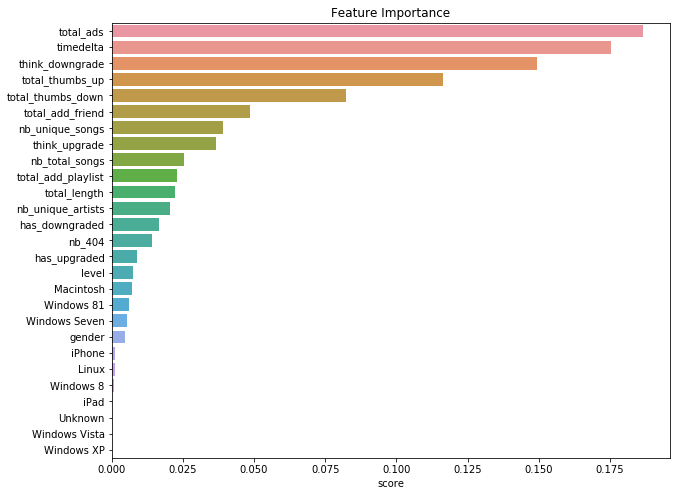

In [112]:
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
sns.barplot(x='score', y='name', data=df_feat_importance, ax=axis)
plt.title('Feature Importance')
plt.ylabel('');

***Observations:***
* In this dataset and with the features I have created, **the one that contributes the most to determine if a user will churn or not is the total number of ads listened**. That would mean that users are fed up with ads and decide to quit.
* The second one is the **number of days of the service** (probably the less you use the more you might churn - we have seen that during the exploration phase)
* Just after comes the **social interactions with the service (either thumbs up or down) meaning that you are satisfied or not with the songs that are suggested** by the service for example.
* On the other side, we can see that the **user's operating system has few importance**. As it was quite painful to collect I suggest that we get rid of that information as a further improvement of this model. The data collect pipeline would be much more faster.

---
# CONCLUSION
We now have a model that can detect churn users with a pretty good performance (F1-Score is 0.82 with good precision and recall).  
We could use this model on the whole database of users, classify them and give the list of users that might soon churn to a commercial/marketing service that can contact them and propose incentives for them to stay.